In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import numpy as np
from AIModel import DNN
import os

df_ref = pd.read_csv("csv/final_dataset.csv")
frequencies = ast.literal_eval(df_ref["freqs[Hz]"][0])
df = pd.read_csv("csv/training_data_extended.csv")
df

,zeta,RPM_Average,Lws
0,0.000000,2710.863636,"[48.64300983673778, 65.01242522683135, 88.8740..."
1,0.000000,2729.057692,"[63.532159255691944, 70.69054519292442, 90.900..."
2,0.000000,2726.692308,"[55.654835278872135, 55.8704568386677, 95.2124..."
3,0.000000,2727.788462,"[52.40809486964445, 65.3997799324605, 91.61007..."
4,0.000000,2723.821429,"[50.379055588447784, 56.398399392972685, 89.26..."
...,...,...,...
415,4.708898,2701.767857,"[49.36627175522353, 57.403099198953086, 62.665..."
416,4.708898,2706.000000,"[41.659347544774846, 45.31318835792328, 64.840..."
417,4.708898,2709.333333,"[49.88871911548689, 51.229446849895396, 61.292..."
418,4.708898,2699.590909,"[50.05031965634466, 47.73858390801173, 50.3631..."


In [2]:
seed = 43

X = df[['zeta', 'RPM_Average']].values
y = np.array([ast.literal_eval(lws) for lws in df['Lws']])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model = DNN(input_dim, output_dim, X_train)

if os.path.exists('sound_model_1.pth'):
    model.load_state_dict(torch.load('sound_model_1.pth'))
else:
    train_losses, val_losses, best_epoch, total_training_time = model.train_model(X_train, y_train, X_val, y_val, num_epochs=50000, patience=5000, verbose=True)
    # Save model
    torch.save(model.state_dict(), 'sound_model_1.pth')

In [3]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model.predict(X_test)
    actual_Lw_total = y_test.numpy().mean(axis=1)
    predicted_Lw_total = y_pred.mean(axis=1)
    mape = np.mean(np.abs((actual_Lw_total - predicted_Lw_total)) / actual_Lw_total) * 100
    rmse = np.sqrt(np.mean((actual_Lw_total - predicted_Lw_total) ** 2))
    mae = np.mean(np.abs(actual_Lw_total - predicted_Lw_total))
    print(f'MAPE: {mape:.2f}%, RMSE: {rmse:.2f} dB, MAE: {mae:.2f} dB')

MAPE: 3.64%, RMSE: 2.95 dB, MAE: 2.14 dB


In [4]:
def calculate_loudness(SWL):
    SWL_rms = np.sqrt(np.mean(SWL**2))
    SWL_loudness_db = 20 * np.log10(SWL_rms)
    return SWL_loudness_db

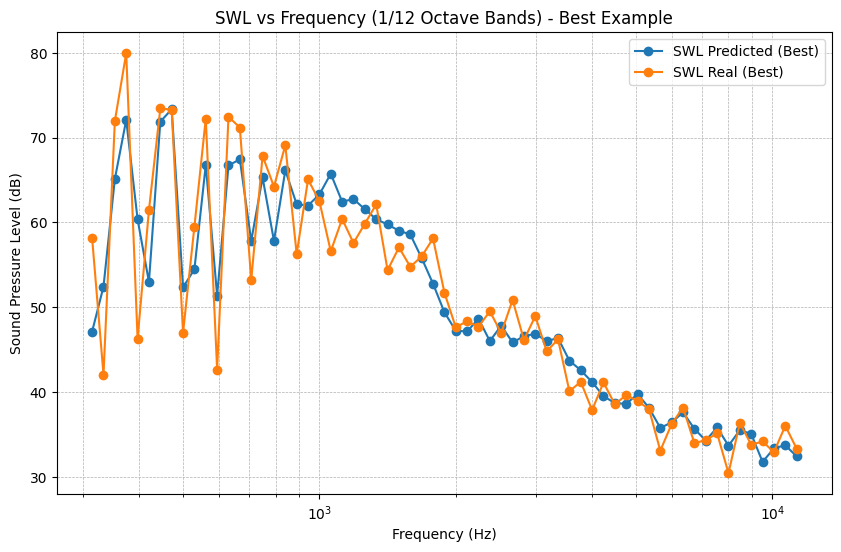

SWL Predicted Mean Loudness: 34.06 dB
SWL Real Mean Loudness: 34.06 dB
Best Example Input:
zeta                                                    0.321141
RPM_Average                                          2722.020833
Lws            [49.288358763059215, 55.439617145927116, 82.01...
Name: 23, dtype: object


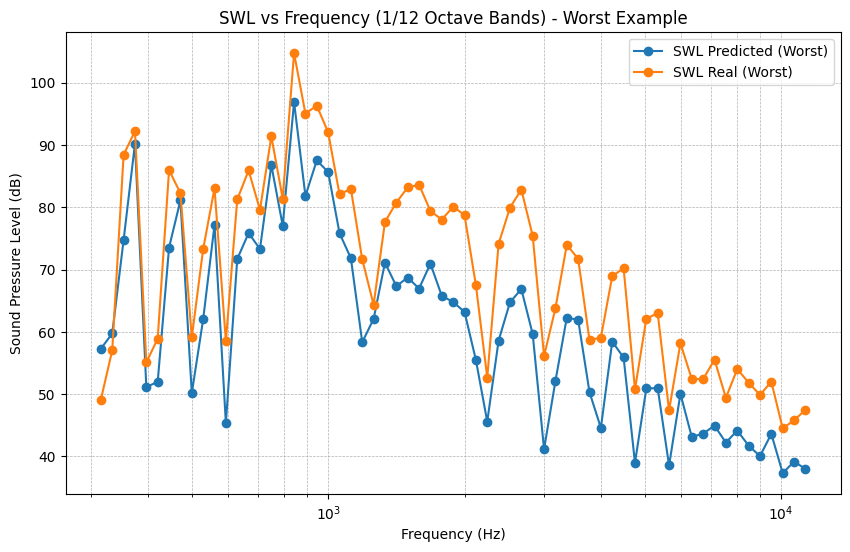

SWL Predicted Mean Loudness: 35.57 dB
SWL Real Mean Loudness: 36.85 dB

Worst Example Input:
zeta                                                    0.321141
RPM_Average                                              2711.35
Lws            [52.739166917878606, 63.43949931523041, 102.80...
Name: 25, dtype: object


In [5]:
output_dir = 'output'

# Calculate the errors for each example in the test set
errors = np.abs((actual_Lw_total - predicted_Lw_total)) / actual_Lw_total

# Find the indices of the best and worst examples
best_example_idx = np.argmin(errors)
worst_example_idx = np.argmax(errors)

# Plot the best example
SWL_predicted_best = y_pred[best_example_idx]
SWL_real_best = y_test[best_example_idx]

plt.figure(figsize=(10, 6))
plt.semilogx(frequencies, SWL_predicted_best, marker='o', linestyle='-', label='SWL Predicted (Best)')
plt.semilogx(frequencies, SWL_real_best, marker='o', linestyle='-', label='SWL Real (Best)')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Sound Pressure Level (dB)')
plt.title('SWL vs Frequency (1/12 Octave Bands) - Best Example')
plt.legend()
plt.savefig(os.path.join(output_dir, 'best_example_plot.png'))
plt.show()


# Calculate the loudness for the predicted and real SWL
SWL_predicted_loudness_db = calculate_loudness(SWL_predicted_best.mean())
SWL_real_loudness_db = calculate_loudness(SWL_real_best.numpy().mean())

print(f"SWL Predicted Mean Loudness: {SWL_predicted_loudness_db:.2f} dB")
print(f"SWL Real Mean Loudness: {SWL_real_loudness_db:.2f} dB")

# Print the input information of the best example
print("Best Example Input:")
print(df.iloc[best_example_idx])

# Plot the worst example
SWL_predicted_worst = y_pred[worst_example_idx]
SWL_real_worst = y_test[worst_example_idx]

plt.figure(figsize=(10, 6))
plt.semilogx(frequencies, SWL_predicted_worst, marker='o', linestyle='-', label='SWL Predicted (Worst)')
plt.semilogx(frequencies, SWL_real_worst, marker='o', linestyle='-', label='SWL Real (Worst)')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Sound Pressure Level (dB)')
plt.title('SWL vs Frequency (1/12 Octave Bands) - Worst Example')
plt.legend()
plt.savefig(os.path.join(output_dir, 'worst_example_plot.png'))
plt.show()

# Calculate the loudness for the predicted and real SWL
SWL_predicted_loudness_db = calculate_loudness(SWL_predicted_worst.mean())
SWL_real_loudness_db = calculate_loudness(SWL_real_worst.numpy().mean())

print(f"SWL Predicted Mean Loudness: {SWL_predicted_loudness_db:.2f} dB")
print(f"SWL Real Mean Loudness: {SWL_real_loudness_db:.2f} dB")

# Print the input information of the worst example
print("\nWorst Example Input:")
print(df.iloc[worst_example_idx])

In [ ]:
model.eval()
with torch.no_grad():
    angles_swl = []
    for angle in range(0, 360, 1):
        angle_in_radiants = np.radians(angle)
        pred = model.predict(np.array([[angle_in_radiants, 2720]]))
        angles_swl.append(pred)

np.save('lookup_noise_model.npy', np.array(angles_swl))

[array([[56.55611 , 60.792713, 89.26908 , 90.06561 , 86.96143 , 64.89406 ,
        93.72159 , 93.22733 , 82.85658 , 74.30827 , 78.46326 , 76.56475 ,
        75.98345 , 85.39648 , 86.39496 , 93.31966 , 89.7424  , 95.07102 ,
        94.13352 , 88.28833 , 86.841286, 81.37386 , 71.433685, 56.49567 ,
        64.633026, 66.9385  , 69.47511 , 68.34911 , 66.413506, 66.321945,
        64.85842 , 62.962456, 57.724667, 53.983738, 43.51656 , 56.707954,
        60.447414, 61.7863  , 57.468624, 40.071125, 50.291847, 59.10338 ,
        58.125603, 46.238537, 42.493893, 56.088642, 53.527573, 36.89936 ,
        51.127018, 51.668118, 35.69009 , 48.412453, 41.994442, 43.65742 ,
        44.42624 , 40.337555, 44.07806 , 39.61099 , 38.248978, 41.42891 ,
        35.86605 , 37.398487, 39.380135]], dtype=float32), array([[56.27431 , 60.80535 , 89.35671 , 90.23944 , 86.77265 , 64.92375 ,
        93.608894, 93.00654 , 82.74546 , 73.74594 , 77.44562 , 75.06976 ,
        75.68456 , 84.57031 , 85.52535 , 92.824135, 

In [22]:
model.eval()
with torch.no_grad():
    angles_swl = []
    for angle in range(0, 360, 1):
        angle_in_radiants = np.radians(angle)
        pred = model.predict(np.array([[angle_in_radiants, 2720]]))
        lw_pred = max(pred.mean(axis=1)[0], 0)
        print(f"Angle: {angle}, Predicted Loudness: {lw_pred:.2f} dB")
        angles_swl.append(lw_pred)

print(angles_swl)
# Save angles_swl as numpy array in file
np.save('angles_swl.npy', angles_swl)

Angle: 0, Predicted Loudness: 62.70 dB
Angle: 1, Predicted Loudness: 62.62 dB
Angle: 2, Predicted Loudness: 62.54 dB
Angle: 3, Predicted Loudness: 62.46 dB
Angle: 4, Predicted Loudness: 62.38 dB
Angle: 5, Predicted Loudness: 62.43 dB
Angle: 6, Predicted Loudness: 62.60 dB
Angle: 7, Predicted Loudness: 62.77 dB
Angle: 8, Predicted Loudness: 62.94 dB
Angle: 9, Predicted Loudness: 63.05 dB
Angle: 10, Predicted Loudness: 63.12 dB
Angle: 11, Predicted Loudness: 63.19 dB
Angle: 12, Predicted Loudness: 63.26 dB
Angle: 13, Predicted Loudness: 63.32 dB
Angle: 14, Predicted Loudness: 63.39 dB
Angle: 15, Predicted Loudness: 63.45 dB
Angle: 16, Predicted Loudness: 63.51 dB
Angle: 17, Predicted Loudness: 63.57 dB
Angle: 18, Predicted Loudness: 63.61 dB
Angle: 19, Predicted Loudness: 63.35 dB
Angle: 20, Predicted Loudness: 63.09 dB
Angle: 21, Predicted Loudness: 62.82 dB
Angle: 22, Predicted Loudness: 62.56 dB
Angle: 23, Predicted Loudness: 62.30 dB
Angle: 24, Predicted Loudness: 62.04 dB
Angle: 25,